# Classification of Topics Based on Question

In [1]:
# !pip install lightgbm
# !pip install -U gensim
# !pip install lime
# !pip install shap

In [2]:
# Import libraries

# Usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import string
import random

# NLTK
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Assigning variables
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop_words = stopwords.words('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as gbm
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Doc/Word Vectors
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# LIME and SHAP
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import shap

# Set seed
np.random.seed(123)

In [3]:
# Import dataset
df = pd.read_csv('Customer_Service_Questions_Multiclass.csv')
df.head()

question             topic
0  Hi! If I sign up for your email list, can I se...  Sales/Promotions
1  I'm going to be out of the country for about a...          Shipping
2  I was wondering if you'd be able to overnight ...          Shipping
3  The Swingline electronic stapler (472555) look...          Shipping
4  I think this cosmetic bag would work great for...          Shipping

In [4]:
# Check for null values

df.isna().sum()

question    0
topic       0
dtype: int64

## Split the data

In [5]:
# Define the target and the input variables

target = df['topic']
input_data = df['question']

In [6]:
# Split into train and test variables

train_set, test_set, train_y, test_y = train_test_split(input_data, target, test_size=0.3, random_state=123)

train_set.shape, train_y.shape, test_set.shape, test_y.shape

((3500,), (3500,), (1500,), (1500,))

## Clean the data

In [7]:
# Loop through the training set and clean the data

new_train = []

for text in train_set:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()               # Remove punctuation and make the letters lowercase
        
    words = nltk.tokenize.word_tokenize(text)                                           # Tokenize the text
    words = [w for w in words if w.isalpha()]                                           # Ensure the data is alphabets (remove numbers)
    words = [w for w in words if len(w)>2 and w not in stopwords.words('english')]      # Remove words that are less than 2 characters and stop words as well
        
    words = [lemmatizer.lemmatize(w) for w in words]                                    # Lemmatize the words
    new_train.append(' '.join(words))

# Convert training set into a dataframe and add the cleaned text into a new column
train_set_df = pd.DataFrame(train_set)
train_set_df['new_text'] = new_train
train_set_df

question  \
1840  If I order the Cobra radar detector (mpn242734...   
2115  On average, how long does it take for you guys...   
4437  I think I want to get the Stripe Blanket & Sha...   
1146  Is there a tag on this sewater- 241670 that wi...   
2486  Do you have any free shipping promotions happe...   
...                                                 ...   
4426  I think I want to get the Nylon camo bomber ja...   
466   Is there a step up from your standard shipping...   
3092  Do you have any sales right now on eyeshadow p...   
3772  I want to get the Chunky Wool rug (Item: 73105...   
860   For product returns on something like style nu...   

                                               new_text  
1840  order cobra radar detector decide want whistle...  
2115  average long take guy process return intereste...  
4437  think want get stripe blanket sham item number...  
1146  tag sewater wash dry instruction clean appropr...  
2486  free shipping promotion happening moment item ...  
...                                                 ...  
4426  think want get nylon camo bomber jacket like l...  
466   step standard shipping something quicker overn...  
3092                      sale right eyeshadow pallates  
3772  want get chunky wool rug item gift mother woul...  
860   product return something like style number get...  

[3500 rows x 2 columns]

In [8]:
# Perform data cleaning on the test set as well

new_test = []

for text in test_set:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()
        
    words= nltk.tokenize.word_tokenize(text)
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if len(w)>2 and w not in stopwords.words('english')]
        
    words = [lemmatizer.lemmatize(w) for w in words]
    new_test.append(' '.join(words))


# Convert training set into a dataframe and add the cleaned text into a new column
test_set_df = pd.DataFrame(test_set)
test_set_df['new_text'] = new_test
test_set_df

question  \
1501  Do you offer email tracking on items that are ...   
2586  Do you ever post any discount codes or special...   
2653  What's the inseam length on the Hotty Hot Shor...   
1055  How much would it cost to ship the Single trav...   
705   I have been searching for a non-stick spring f...   
...                                                 ...   
3563  What kind of immediate benefits would I get if...   
1538  Do you have any gluten free protein bars that ...   
1837  Would there be any limitations to returning so...   
2380  Do you know if the crewneck sweatshirt ITEM# R...   
1912  Is there a way to subscribe to receive notific...   

                                               new_text  
1501  offer email tracking item returned issue compa...  
2586  ever post discount code special deal social me...  
2653        inseam length hotty hot short interior mesh  
1055  much would cost ship single travel hammock usi...  
705   searching non stick spring form panis somethin...  
...                                                 ...  
3563  kind immediate benefit would get sign gnc account  
1538     gluten free protein bar peanut butter flavored  
1837  would limitation returning something kind big ...  
2380               know crewneck sweatshirt item cotton  
1912  way subscribe receive notification sale promo ...  

[1500 rows x 2 columns]

In [9]:
# # Function to run and evaluate classifiers

# def model(classifier, train_x, test_x):
#     classifier.fit(train_x, train_y)  
#     pred_y = classifier.predict(test_x)
#     accuracy = accuracy_score(test_y, pred_y)
#     recall = recall_score(pred_y, test_y, average='weighted') 
#     precision = precision_score(pred_y, test_y, average='weighted')  
#     f1score = f1_score(pred_y, test_y, average='weighted')

#     print('Accuracy: {:.3f}\n'.format(accuracy))
#     print("")
#     print("Confusion Matrix")
#     print(confusion_matrix(test_y, pred_y))
#     print("")
#     print("Classification Report")
#     print(classification_report(test_y, pred_y))
#     return 

## TF-IDF Vector of Tokenized Words

In [10]:
# Define the TF-IDF vectorizer model
tfidf_vect = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase= True, analyzer='word')

# Transform and fit training and text sets
train_x_tfidf = tfidf_vect.fit_transform(train_set_df['new_text'])
test_x_tfidf = tfidf_vect.transform(test_set_df['new_text'])

In [11]:
# Check the shape of the transformed variables

train_x_tfidf.shape, test_x_tfidf.shape

((3500, 4155), (1500, 4155))

### Logistic Regression

In [12]:
# Define the model

lr_model = LogisticRegression(penalty='elasticnet', n_jobs =-1, solver = 'saga', l1_ratio = 0.1)

In [13]:
# Fit and Run the model

# Fit the model
lr_model.fit(train_x_tfidf, train_y)

# 5-Fold Cross Validation
cv_accuracy = cross_val_score(lr_model, train_x_tfidf, train_y, cv=5)

# Predict
pred_y = lr_model.predict(test_x_tfidf)

# Gather Metrices
cv_mean_accuracy = np.mean(cv_accuracy)
accuracy = accuracy_score(test_y, pred_y)
recall = recall_score(pred_y, test_y, average='weighted') 
precision = precision_score(pred_y, test_y, average='weighted')  
f1score = f1_score(pred_y, test_y, average='weighted')

# Print Results
print('CV Accuracy (5-fold):', cv_accuracy)
print("")
print('Mean CV Accuracy: ', cv_mean_accuracy.round(3))
print("")
print('Accuracy: {:.3f}\n'.format(accuracy))
print("")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_y))
print("")
print("Classification Report")
print(classification_report(test_y, pred_y))

# Add the metrices into a dataframe
metrics_lr_tfidf_vect = pd.DataFrame([['LogisticRegression', 'TF-IDF Vector', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lr_tfidf_vect

CV Accuracy (5-fold): [0.91571429 0.93428571 0.93142857 0.93428571 0.92857143]

Mean CV Accuracy:  0.929

Accuracy: 0.930


Confusion Matrix
[[127   2   0   0   1   0   1]
 [  0 222  10   3   1   0   0]
 [  0  13 211  23   0   0   0]
 [  0  13  21 219   0   0   0]
 [  0   0   3   0 245   0   0]
 [  0   6   0   4   0 142   0]
 [  0   0   0   3   0   1 229]]

Classification Report
                        precision    recall  f1-score   support

           Omnichannel       1.00      0.97      0.98       131
  Product Availability       0.87      0.94      0.90       236
    Product Comparison       0.86      0.85      0.86       247
Product Specifications       0.87      0.87      0.87       253
     Returns & Refunds       0.99      0.99      0.99       248
      Sales/Promotions       0.99      0.93      0.96       152
              Shipping       1.00      0.98      0.99       233

              accuracy                           0.93      1500
             macro avg       0.94      0

Classification_Model  Training_Data  Recall  Precision  F1_Score  Accuracy
0   LogisticRegression  TF-IDF Vector    0.93   0.930012  0.929635      0.93

### XGBoost

In [14]:
# Define the model
xgb_model = xgb.XGBClassifier(booster = 'dart', eval_metric = 'mlogloss', n_jobs = -1)

In [15]:
# Fit and Run the model

# Fit the model
xgb_model.fit(train_x_tfidf, train_y)

# 5-Fold Cross Validation
cv_accuracy = cross_val_score(xgb_model, train_x_tfidf, train_y, cv=5)

# Predict
pred_y = xgb_model.predict(test_x_tfidf)

# Gather Metrices
cv_mean_accuracy = np.mean(cv_accuracy)
accuracy = accuracy_score(test_y, pred_y)
recall = recall_score(pred_y, test_y, average='weighted') 
precision = precision_score(pred_y, test_y, average='weighted')  
f1score = f1_score(pred_y, test_y, average='weighted')

# Print Results
print('CV Accuracy (5-fold):', cv_accuracy)
print("")
print('Mean CV Accuracy: ', cv_mean_accuracy.round(3))
print("")
print('Accuracy: {:.3f}\n'.format(accuracy))
print("")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_y))
print("")
print("Classification Report")
print(classification_report(test_y, pred_y))

# Add the metrices into a dataframe
metrics_xgb_tfidf_vect = pd.DataFrame([['XGBoost', 'TF-IDF Vector', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_xgb_tfidf_vect

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

CV Accuracy (5-fold): [0.92714286 0.95       0.92571429 0.94428571 0.92285714]

Mean CV Accuracy:  0.934

Accuracy: 0.942


Confusion Matrix
[[130   1   0   0   0   0   0]
 [  0 221   9   5   1   0   0]
 [  0  10 222  15   0   0   0]
 [  1  15  13 223   1   0   0]
 [  1   0   0   0 247   0   0]
 [  1   5   2   3   1 140   0]
 [  0   1   0   2   0   0 230]]

Classification Report
                        precision    recall  f1-score   support

           Omnichannel       0.98      0.99      0.98       131
  Product Availability       0.87      0.94      0.90       236
    Product Comparison       0.90      0.90      0.90       247
Product Specifications       0.90      0.88      0.89       253
     Returns & Refunds       0.99      1.00      0.99       248
      Sales/Promotions       1.00      0.92      0.96       152
              Shipping       1.00      0.99      0.99       233

              accuracy                           0.94      1500
             macro avg       0.95      0

Classification_Model  Training_Data  Recall  Precision  F1_Score  Accuracy
0              XGBoost  TF-IDF Vector   0.942   0.942384  0.941827     0.942

### LightGBM

In [16]:
# LightGBM
lgbm_model = LGBMClassifier(boosting_type = 'dart', max_depth = 30, learning_rate = 0.1, metric = 'multi_logloss')

In [17]:
# Fit and Run the model

# Fit the model
lgbm_model.fit(train_x_tfidf, train_y)

# 5-Fold Cross Validation
cv_accuracy = cross_val_score(lgbm_model, train_x_tfidf, train_y, cv=5)

# Predict
pred_y = lgbm_model.predict(test_x_tfidf)

# Gather Metrices
cv_mean_accuracy = np.mean(cv_accuracy)
accuracy = accuracy_score(test_y, pred_y)
recall = recall_score(pred_y, test_y, average='weighted') 
precision = precision_score(pred_y, test_y, average='weighted')  
f1score = f1_score(pred_y, test_y, average='weighted')

# Print Results
print('CV Accuracy (5-fold):', cv_accuracy)
print("")
print('Mean CV Accuracy: ', cv_mean_accuracy.round(3))
print("")
print('Accuracy: {:.3f}\n'.format(accuracy))
print("")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_y))
print("")
print("Classification Report")
print(classification_report(test_y, pred_y))

# Add the metrices into a dataframe
metrics_lgbm_tfidf_vect = pd.DataFrame([['LightGBM', 'TF-IDF Vector', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lgbm_tfidf_vect

CV Accuracy (5-fold): [0.92714286 0.93       0.91857143 0.91714286 0.91857143]

Mean CV Accuracy:  0.922

Accuracy: 0.929


Confusion Matrix
[[126   1   0   2   1   0   1]
 [  0 215   8  11   1   1   0]
 [  1  12 214  20   0   0   0]
 [  1  14  15 223   0   0   0]
 [  1   0   0   0 246   1   0]
 [  1   6   0   3   1 141   0]
 [  0   2   0   1   0   1 229]]

Classification Report
                        precision    recall  f1-score   support

           Omnichannel       0.97      0.96      0.97       131
  Product Availability       0.86      0.91      0.88       236
    Product Comparison       0.90      0.87      0.88       247
Product Specifications       0.86      0.88      0.87       253
     Returns & Refunds       0.99      0.99      0.99       248
      Sales/Promotions       0.98      0.93      0.95       152
              Shipping       1.00      0.98      0.99       233

              accuracy                           0.93      1500
             macro avg       0.94      0

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0             LightGBM  TF-IDF Vector  0.929333   0.929281  0.929022  0.929333

### Metrices Concatenation (TF-IDF Vector)

In [18]:
metrics_tfidf_vect = pd.concat([metrics_lr_tfidf_vect, metrics_xgb_tfidf_vect, metrics_lgbm_tfidf_vect])

metrics_tfidf_vect.sort_values(by= 'F1_Score', ascending=False)

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0              XGBoost  TF-IDF Vector  0.942000   0.942384  0.941827  0.942000
0   LogisticRegression  TF-IDF Vector  0.930000   0.930012  0.929635  0.930000
0             LightGBM  TF-IDF Vector  0.929333   0.929281  0.929022  0.929333

## TF-IDF Vector of ngrams

In [19]:
# Define the TF-IDF with ngrams model
tfidf_ngrams = TfidfVectorizer(strip_accents='ascii', stop_words='english', ngram_range=(4,5))

# Transform and fit training and text sets
train_x_ngrams = tfidf_ngrams.fit_transform(train_set_df['new_text'])
test_x_ngrams = tfidf_ngrams.transform(test_set_df['new_text'])

In [20]:
# Check the shape of the transformed variables

train_x_ngrams.shape, test_x_ngrams.shape

((3500, 37669), (1500, 37669))

### Logistic Regression

In [21]:
# Define the model
lr_model = LogisticRegression(penalty='elasticnet', n_jobs =-1, solver = 'saga', l1_ratio = 0)

In [22]:
# Fit and Run the model

# Fit the model
lr_model.fit(train_x_ngrams, train_y)

# 5-Fold Cross Validation
cv_accuracy = cross_val_score(lr_model, train_x_tfidf, train_y, cv=5)

# Predict
pred_y = lr_model.predict(test_x_ngrams)

# Gather Metrices
cv_mean_accuracy = np.mean(cv_accuracy)
accuracy = accuracy_score(test_y, pred_y)
recall = recall_score(pred_y, test_y, average='weighted') 
precision = precision_score(pred_y, test_y, average='weighted')  
f1score = f1_score(pred_y, test_y, average='weighted')

# Print Results
print('CV Accuracy (5-fold):', cv_accuracy)
print("")
print('Mean CV Accuracy: ', cv_mean_accuracy.round(3))
print("")
print('Accuracy: {:.3f}\n'.format(accuracy))
print("")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_y))
print("")
print("Classification Report")
print(classification_report(test_y, pred_y))

# Add the metrices into a dataframe
metrics_lr_tfidf_ngrams = pd.DataFrame([['LogisticRegression', 'TF-IDF Ngrams', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lr_tfidf_ngrams

CV Accuracy (5-fold): [0.92       0.93857143 0.92857143 0.93571429 0.93285714]

Mean CV Accuracy:  0.931

Accuracy: 0.795


Confusion Matrix
[[ 81   0   0  50   0   0   0]
 [  0 164   1  71   0   0   0]
 [  0   0 152  95   0   0   0]
 [  0   0  12 241   0   0   0]
 [  0   0   0  16 232   0   0]
 [  0   0   0  41   0 111   0]
 [  0   0   1  21   0   0 211]]

Classification Report
                        precision    recall  f1-score   support

           Omnichannel       1.00      0.62      0.76       131
  Product Availability       1.00      0.69      0.82       236
    Product Comparison       0.92      0.62      0.74       247
Product Specifications       0.45      0.95      0.61       253
     Returns & Refunds       1.00      0.94      0.97       248
      Sales/Promotions       1.00      0.73      0.84       152
              Shipping       1.00      0.91      0.95       233

              accuracy                           0.79      1500
             macro avg       0.91      0

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0   LogisticRegression  TF-IDF Ngrams  0.794667   0.843331  0.776213  0.794667

### XGBoost

In [23]:
# Define the model
xgb_model = xgb.XGBClassifier(booster = 'gblinear', eval_metric = 'mlogloss', n_jobs = -1, eta = 0.9)

In [24]:
# Fit and Run the model

# Fit the model
xgb_model.fit(train_x_ngrams, train_y)

# 5-Fold Cross Validation
cv_accuracy = cross_val_score(xgb_model, train_x_tfidf, train_y, cv=5)

# Predict
pred_y = xgb_model.predict(test_x_ngrams)

# Gather Metrices
cv_mean_accuracy = np.mean(cv_accuracy)
accuracy = accuracy_score(test_y, pred_y)
recall = recall_score(pred_y, test_y, average='weighted') 
precision = precision_score(pred_y, test_y, average='weighted')  
f1score = f1_score(pred_y, test_y, average='weighted')

# Print Results
print('CV Accuracy (5-fold):', cv_accuracy)
print("")
print('Mean CV Accuracy: ', cv_mean_accuracy.round(3))
print("")
print('Accuracy: {:.3f}\n'.format(accuracy))
print("")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_y))
print("")
print("Classification Report")
print(classification_report(test_y, pred_y))

# Add the metrices into a dataframe
metrics_xgb_tfidf_ngrams = pd.DataFrame([['XGBoost', 'TF-IDF Ngrams', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])
metrics_xgb_tfidf_ngrams

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

CV Accuracy (5-fold): [0.90285714 0.93857143 0.93       0.92428571 0.93714286]

Mean CV Accuracy:  0.927

Accuracy: 0.725


Confusion Matrix
[[130   0   0   1   0   0   0]
 [ 75 160   1   0   0   0   0]
 [114   0 133   0   0   0   0]
 [137   1   5 108   0   0   2]
 [ 19   0   0   1 228   0   0]
 [ 35   0   0   0   0 117   0]
 [ 21   0   1   0   0   0 211]]

Classification Report
                        precision    recall  f1-score   support

           Omnichannel       0.24      0.99      0.39       131
  Product Availability       0.99      0.68      0.81       236
    Product Comparison       0.95      0.54      0.69       247
Product Specifications       0.98      0.43      0.60       253
     Returns & Refunds       1.00      0.92      0.96       248
      Sales/Promotions       1.00      0.77      0.87       152
              Shipping       0.99      0.91      0.95       233

              accuracy                           0.72      1500
             macro avg       0.88      0

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0              XGBoost  TF-IDF Ngrams  0.724667   0.834001   0.68116  0.724667

### LightGBM

In [25]:
# LightGBM
lgbm_model = LGBMClassifier(boosting_type = 'dart', max_depth = 30, learning_rate = 0.1, metric = 'multi_logloss')

In [26]:
# Fit and Run the model

# Fit the model
lgbm_model.fit(train_x_ngrams, train_y)

# 5-Fold Cross Validation
cv_accuracy = cross_val_score(lgbm_model, train_x_tfidf, train_y, cv=5)

# Predict
pred_y = lgbm_model.predict(test_x_ngrams)

# Gather Metrices
cv_mean_accuracy = np.mean(cv_accuracy)
accuracy = accuracy_score(test_y, pred_y)
recall = recall_score(pred_y, test_y, average='weighted') 
precision = precision_score(pred_y, test_y, average='weighted')  
f1score = f1_score(pred_y, test_y, average='weighted')

# Print Results
print('CV Accuracy (5-fold):', cv_accuracy)
print("")
print('Mean CV Accuracy: ', cv_mean_accuracy.round(3))
print("")
print('Accuracy: {:.3f}\n'.format(accuracy))
print("")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_y))
print("")
print("Classification Report")
print(classification_report(test_y, pred_y))

# Add the metrices into a dataframe
metrics_lgbm_tfidf_ngrams = pd.DataFrame([['LightGBM', 'TF-IDF Ngrams', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lgbm_tfidf_ngrams

CV Accuracy (5-fold): [0.92714286 0.93       0.91857143 0.91714286 0.91857143]

Mean CV Accuracy:  0.922

Accuracy: 0.301


Confusion Matrix
[[ 17 114   0   0   0   0   0]
 [  0 236   0   0   0   0   0]
 [  0 233  14   0   0   0   0]
 [  0 247   0   6   0   0   0]
 [  0 144   0   0 104   0   0]
 [  0 141   0   0   0  11   0]
 [  0 169   0   0   0   0  64]]

Classification Report
                        precision    recall  f1-score   support

           Omnichannel       1.00      0.13      0.23       131
  Product Availability       0.18      1.00      0.31       236
    Product Comparison       1.00      0.06      0.11       247
Product Specifications       1.00      0.02      0.05       253
     Returns & Refunds       1.00      0.42      0.59       248
      Sales/Promotions       1.00      0.07      0.13       152
              Shipping       1.00      0.27      0.43       233

              accuracy                           0.30      1500
             macro avg       0.88      0

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0             LightGBM  TF-IDF Ngrams  0.301333    0.89942  0.329949  0.301333

### Metrices Concatenation (TF-IDF Ngrams)

In [27]:
metrics_tfidf_vect_ngrams = pd.concat([metrics_lr_tfidf_ngrams, metrics_xgb_tfidf_ngrams, metrics_lgbm_tfidf_ngrams])

metrics_tfidf_vect_ngrams.sort_values(by= 'F1_Score', ascending=False)

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0   LogisticRegression  TF-IDF Ngrams  0.794667   0.843331  0.776213  0.794667
0              XGBoost  TF-IDF Ngrams  0.724667   0.834001  0.681160  0.724667
0             LightGBM  TF-IDF Ngrams  0.301333   0.899420  0.329949  0.301333

## Word2Vec

### Data Cleaning

In [28]:
df.columns

Index(['question', 'topic'], dtype='object')

In [29]:
# Tokenize the question column
tokenized_list = [simple_preprocess(h) for h in df['question']]

In [30]:
# Split into train and test variables

vec_train_set, vec_test_set, vec_train_y, vec_test_y = train_test_split(np.array(tokenized_list), np.array(df['topic']), test_size=0.3, random_state=123)

vec_train_set.shape, vec_train_y.shape, vec_test_set.shape, vec_test_y.shape

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


((3500,), (3500,), (1500,), (1500,))

In [31]:
# Create a Word2Vec model
w2v_model = Word2Vec(vec_train_set, alpha = 0.03, window=8, min_count=2, sample=1e-5, sg=1, workers=8)

# Build a vocabulary table
vocab = set(w2v_model.wv.index_to_key)
len(vocab)

2913

In [32]:
# Creating a function that will calculate the average Word2Vec vector

num_features = 100

def average_word_vectors(tokens, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    ntokens = 0.
    for t in tokens:
        if t in vocabulary: 
            ntokens = ntokens + 1.
            feature_vector = np.add(feature_vector, model.wv[t])
    if ntokens:
        feature_vector = np.divide(feature_vector, ntokens)
    return feature_vector

In [33]:
# Performing the average calculation on the train set
w2v_train_set = [average_word_vectors(sent_tokens, w2v_model, vocab, num_features) 
               for sent_tokens in vec_train_set]
avg_w2v_train_set = np.array(w2v_train_set)

# Performing the average calculation on the test set
w2v_test_set = [average_word_vectors(sent_tokens, w2v_model, vocab, num_features) 
              for sent_tokens in vec_test_set]
avg_w2v_test_set = np.array(w2v_test_set)

# Checking the shapes 
print('Train features shape:', avg_w2v_train_set.shape, 
      '\nTest features shape:', avg_w2v_test_set.shape)

Train features shape: (3500, 100) 
Test features shape: (1500, 100)


In [34]:
model_train_set = [avg_w2v_train_set]
model_test_set  = [avg_w2v_test_set]
input_model = ['Word2Vec']

### Logistic Regression

In [35]:
# Define the model
lr_model = LogisticRegression(penalty='elasticnet', n_jobs =-1, solver = 'saga', l1_ratio = 0.1)


In [36]:
for i, x in enumerate(model_train_set):
    lr_model.fit(x, train_y)
    lr_cv_accuracy = cross_val_score(lr_model, x, train_y, cv=5)
    print('Input model:', input_model[i], '\n')
    print('CV Accuracy (5-fold):', lr_cv_accuracy)
    
    lr_cv_mean_accuracy = np.mean(lr_cv_accuracy)
    print('Mean CV Accuracy:', lr_cv_mean_accuracy)
    
    accuracy = lr_model.score(model_test_set[i], test_y)
    print('Test Accuracy:', accuracy)

    pred_y = lr_model.predict(model_test_set[i])
    print(classification_report(test_y, pred_y, target_names=df['topic'].unique()))

    recall = recall_score(pred_y, test_y, average='weighted') 
    precision = precision_score(pred_y, test_y, average='weighted')  
    f1score = f1_score(pred_y, test_y, average='weighted') 
    
# Add the metrices into a dataframe
metrics_lr_w2v = pd.DataFrame([['LogisticRegression', 'Word2Vec', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lr_w2v

Input model: Word2Vec 

CV Accuracy (5-fold): [0.24428571 0.24428571 0.23285714 0.22428571 0.23142857]
Mean CV Accuracy: 0.2354285714285714
Test Accuracy: 0.23333333333333334
                        precision    recall  f1-score   support

      Sales/Promotions       0.00      0.00      0.00       131
              Shipping       0.26      0.64      0.37       236
  Product Availability       1.00      0.01      0.02       247
Product Specifications       0.21      0.73      0.33       253
           Omnichannel       0.00      0.00      0.00       248
    Product Comparison       0.00      0.00      0.00       152
     Returns & Refunds       0.43      0.04      0.08       233

              accuracy                           0.23      1500
             macro avg       0.27      0.20      0.11      1500
          weighted avg       0.31      0.23      0.13      1500



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Classification_Model Training_Data    Recall  Precision  F1_Score  Accuracy
0   LogisticRegression      Word2Vec  0.233333   0.685009  0.337765  0.233333

### XGBoost

In [37]:
# Define the model
xgb_model = xgb.XGBClassifier(booster = 'dart', eval_metric = 'mlogloss', n_jobs = -1)

In [38]:
# Fit and make prediction
for i, x in enumerate(model_train_set):
    xgb_model.fit(x, train_y)
    xgb_cv_accuracy = cross_val_score(xgb_model, x, train_y, cv=5)
    print('Input model:', input_model[i], '\n')
    print('CV Accuracy (5-fold):', xgb_cv_accuracy)
    
    xgb_cv_mean_accuracy = np.mean(xgb_cv_accuracy)
    print('Mean CV Accuracy:', xgb_cv_mean_accuracy)
    
    accuracy = xgb_model.score(model_test_set[i], test_y)
    print('Test Accuracy:', accuracy)

    pred_y = xgb_model.predict(model_test_set[i])
    print(classification_report(test_y, pred_y, target_names=df['topic'].unique()))

    recall = recall_score(pred_y, test_y, average='weighted') 
    precision = precision_score(pred_y, test_y, average='weighted')  
    f1score = f1_score(pred_y, test_y, average='weighted') 
    
# Add the metrices into a dataframe
metrics_xgb_w2v = pd.DataFrame([['XGBoost', 'Word2Vec', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_xgb_w2v

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

Input model: Word2Vec 

CV Accuracy (5-fold): [0.86857143 0.87714286 0.83714286 0.87285714 0.84428571]
Mean CV Accuracy: 0.86
Test Accuracy: 0.896
                        precision    recall  f1-score   support

      Sales/Promotions       0.93      0.81      0.87       131
              Shipping       0.93      0.88      0.90       236
  Product Availability       0.83      0.86      0.85       247
Product Specifications       0.85      0.88      0.87       253
           Omnichannel       0.93      0.96      0.94       248
    Product Comparison       0.89      0.88      0.89       152
     Returns & Refunds       0.93      0.96      0.94       233

              accuracy                           0.90      1500
             macro avg       0.90      0.89      0.89      1500
          weighted avg       0.90      0.90      0.90      1500



Classification_Model Training_Data  Recall  Precision  F1_Score  Accuracy
0              XGBoost      Word2Vec   0.896   0.897512   0.89617     0.896

### Light GBM

In [39]:
# Define the model
lgbm_model = LGBMClassifier(boosting_type = 'dart', max_depth = 30, learning_rate = 0.1, metric = 'multi_logloss')

In [40]:
# Fit and make prediction
for i, x in enumerate(model_train_set):
    lgbm_model.fit(x, train_y)
    lgbm_cv_accuracy = cross_val_score(lgbm_model, x, train_y, cv=5)
    print('Input model:', input_model[i], '\n')
    print('CV Accuracy (5-fold):', lgbm_cv_accuracy)
    
    lgbm_cv_mean_accuracy = np.mean(lgbm_cv_accuracy)
    print('Mean CV Accuracy:', lgbm_cv_mean_accuracy)
    
    accuracy = lgbm_model.score(model_test_set[i], test_y)
    print('Test Accuracy:', accuracy)

    pred_y = lgbm_model.predict(model_test_set[i])
    print(classification_report(test_y, pred_y, target_names=df['topic'].unique()))

    recall = recall_score(pred_y, test_y, average='weighted') 
    precision = precision_score(pred_y, test_y, average='weighted')  
    f1score = f1_score(pred_y, test_y, average='weighted') 
    
# Add the metrices into a dataframe
metrics_lgbm_w2v = pd.DataFrame([['LightGBM', 'Word2Vec', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lgbm_w2v

Input model: Word2Vec 

CV Accuracy (5-fold): [0.85428571 0.87285714 0.84285714 0.85714286 0.83142857]
Mean CV Accuracy: 0.8517142857142858
Test Accuracy: 0.89
                        precision    recall  f1-score   support

      Sales/Promotions       0.93      0.77      0.84       131
              Shipping       0.94      0.88      0.91       236
  Product Availability       0.80      0.88      0.84       247
Product Specifications       0.83      0.85      0.84       253
           Omnichannel       0.94      0.96      0.95       248
    Product Comparison       0.92      0.88      0.90       152
     Returns & Refunds       0.93      0.96      0.94       233

              accuracy                           0.89      1500
             macro avg       0.90      0.88      0.89      1500
          weighted avg       0.89      0.89      0.89      1500



Classification_Model Training_Data  Recall  Precision  F1_Score  Accuracy
0             LightGBM      Word2Vec    0.89   0.892249  0.889976      0.89

### Metrices Concatenation (Word2Vec)

In [41]:
metrics_w2v = pd.concat([metrics_lr_w2v, metrics_xgb_w2v, metrics_lgbm_w2v])

metrics_w2v.sort_values(by= 'F1_Score', ascending=False)

Classification_Model Training_Data    Recall  Precision  F1_Score  Accuracy
0              XGBoost      Word2Vec  0.896000   0.897512  0.896170  0.896000
0             LightGBM      Word2Vec  0.890000   0.892249  0.889976  0.890000
0   LogisticRegression      Word2Vec  0.233333   0.685009  0.337765  0.233333

## Doc2Vec

### Data Cleaning

In [42]:
# Define the Doc2Vec model
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(vec_train_set)]
d2v = Doc2Vec(vector_size=100, window=3, min_count=4, workers=4, epochs=40)

# Build the vocabulary
d2v.build_vocab(docs)

# Train the model
d2v.train(docs, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [43]:
# Vectorise the training the testing sets

d2v_train_set = [d2v.infer_vector(i) for i in vec_train_set]
d2v_test_set =  [d2v.infer_vector(i) for i in vec_test_set]

input_model = ['Doc2Vec']

### Logistic Regression

In [44]:
# Define the model
lr_model = LogisticRegression(penalty='elasticnet', n_jobs =-1, solver = 'saga', l1_ratio = 0.1)

In [45]:
for i, x in enumerate(model_train_set):
    lr_model.fit(x, train_y)
    lr_cv_accuracy = cross_val_score(lr_model, x, train_y, cv=5)
    print('Input model:', input_model[i], '\n')
    print('CV Accuracy (5-fold):', lr_cv_accuracy)
    
    lr_cv_mean_accuracy = np.mean(lr_cv_accuracy)
    print('Mean CV Accuracy:', lr_cv_mean_accuracy)
    
    accuracy = lr_model.score(model_test_set[i], test_y)
    print('Test Accuracy:', accuracy)

    pred_y = lr_model.predict(model_test_set[i])
    print(classification_report(test_y, pred_y, target_names=df['topic'].unique()))

    recall = recall_score(pred_y, test_y, average='weighted') 
    precision = precision_score(pred_y, test_y, average='weighted')  
    f1score = f1_score(pred_y, test_y, average='weighted') 
    
# Add the metrices into a dataframe
metrics_lr_d2v = pd.DataFrame([['LogisticRegression', 'Doc2Vec', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lr_d2v

Input model: Doc2Vec 

CV Accuracy (5-fold): [0.24428571 0.24428571 0.23285714 0.22428571 0.23142857]
Mean CV Accuracy: 0.2354285714285714
Test Accuracy: 0.23266666666666666
                        precision    recall  f1-score   support

      Sales/Promotions       0.00      0.00      0.00       131
              Shipping       0.26      0.64      0.37       236
  Product Availability       1.00      0.01      0.02       247
Product Specifications       0.21      0.73      0.32       253
           Omnichannel       0.00      0.00      0.00       248
    Product Comparison       0.00      0.00      0.00       152
     Returns & Refunds       0.41      0.04      0.07       233

              accuracy                           0.23      1500
             macro avg       0.27      0.20      0.11      1500
          weighted avg       0.30      0.23      0.13      1500



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Classification_Model Training_Data    Recall  Precision  F1_Score  Accuracy
0   LogisticRegression       Doc2Vec  0.232667   0.685405  0.337651  0.232667

### XGBoost

In [46]:
# Define the model
xgb_model = xgb.XGBClassifier(booster = 'dart', eval_metric = 'mlogloss', n_jobs = -1)

In [47]:
# Fit and make prediction
for i, x in enumerate(model_train_set):
    xgb_model.fit(x, train_y)
    xgb_cv_accuracy = cross_val_score(xgb_model, x, train_y, cv=5)
    print('Input model:', input_model[i], '\n')
    print('CV Accuracy (5-fold):', xgb_cv_accuracy)
    
    xgb_cv_mean_accuracy = np.mean(xgb_cv_accuracy)
    print('Mean CV Accuracy:', xgb_cv_mean_accuracy)
    
    accuracy = xgb_model.score(model_test_set[i], test_y)
    print('Test Accuracy:', accuracy)

    pred_y = xgb_model.predict(model_test_set[i])
    print(classification_report(test_y, pred_y, target_names=df['topic'].unique()))

    recall = recall_score(pred_y, test_y, average='weighted') 
    precision = precision_score(pred_y, test_y, average='weighted')  
    f1score = f1_score(pred_y, test_y, average='weighted') 

# Add the metrices into a dataframe
metrics_xgb_d2v = pd.DataFrame([['XGBoost', 'Doc2Vec', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_xgb_d2v

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

Input model: Doc2Vec 

CV Accuracy (5-fold): [0.86857143 0.87714286 0.83714286 0.87285714 0.84428571]
Mean CV Accuracy: 0.86
Test Accuracy: 0.896
                        precision    recall  f1-score   support

      Sales/Promotions       0.93      0.81      0.87       131
              Shipping       0.93      0.88      0.90       236
  Product Availability       0.83      0.86      0.85       247
Product Specifications       0.85      0.88      0.87       253
           Omnichannel       0.93      0.96      0.94       248
    Product Comparison       0.89      0.88      0.89       152
     Returns & Refunds       0.93      0.96      0.94       233

              accuracy                           0.90      1500
             macro avg       0.90      0.89      0.89      1500
          weighted avg       0.90      0.90      0.90      1500



Classification_Model Training_Data  Recall  Precision  F1_Score  Accuracy
0              XGBoost       Doc2Vec   0.896   0.897512   0.89617     0.896

### LightGBM

In [48]:
# Define the model
lgbm_model = LGBMClassifier(boosting_type = 'dart', max_depth = 30, learning_rate = 0.1, metric = 'multi_logloss')

In [49]:
# Fit and make prediction
for i, x in enumerate(model_train_set):
    lgbm_model.fit(x, train_y)
    lgbm_cv_accuracy = cross_val_score(lgbm_model, x, train_y, cv=5)
    print('Input model:', input_model[i], '\n')
    print('CV Accuracy (5-fold):', lgbm_cv_accuracy)
    
    lgbm_cv_mean_accuracy = np.mean(lgbm_cv_accuracy)
    print('Mean CV Accuracy:', lgbm_cv_mean_accuracy)
    
    accuracy = lgbm_model.score(model_test_set[i], test_y)
    print('Test Accuracy:', accuracy)

    pred_y = lgbm_model.predict(model_test_set[i])
    print(classification_report(test_y, pred_y, target_names=df['topic'].unique()))

    recall = recall_score(pred_y, test_y, average='weighted') 
    precision = precision_score(pred_y, test_y, average='weighted')  
    f1score = f1_score(pred_y, test_y, average='weighted') 
    
# Add the metrices into a dataframe
metrics_lgbm_d2v = pd.DataFrame([['LightGBM', 'Doc2Vec', recall, precision, f1score, accuracy]], 
    columns = ['Classification_Model', 'Training_Data', 'Recall', 'Precision', 'F1_Score', 'Accuracy'])

metrics_lgbm_d2v

Input model: Doc2Vec 

CV Accuracy (5-fold): [0.85428571 0.87285714 0.84285714 0.85714286 0.83142857]
Mean CV Accuracy: 0.8517142857142858
Test Accuracy: 0.89
                        precision    recall  f1-score   support

      Sales/Promotions       0.93      0.77      0.84       131
              Shipping       0.94      0.88      0.91       236
  Product Availability       0.80      0.88      0.84       247
Product Specifications       0.83      0.85      0.84       253
           Omnichannel       0.94      0.96      0.95       248
    Product Comparison       0.92      0.88      0.90       152
     Returns & Refunds       0.93      0.96      0.94       233

              accuracy                           0.89      1500
             macro avg       0.90      0.88      0.89      1500
          weighted avg       0.89      0.89      0.89      1500



Classification_Model Training_Data  Recall  Precision  F1_Score  Accuracy
0             LightGBM       Doc2Vec    0.89   0.892249  0.889976      0.89

### Metrices Concatenation (Doc2Vec)

In [50]:
metrics_d2v = pd.concat([metrics_lr_d2v, metrics_xgb_d2v, metrics_lgbm_d2v])

metrics_d2v.sort_values(by= 'F1_Score', ascending=False)

Classification_Model Training_Data    Recall  Precision  F1_Score  Accuracy
0              XGBoost       Doc2Vec  0.896000   0.897512  0.896170  0.896000
0             LightGBM       Doc2Vec  0.890000   0.892249  0.889976  0.890000
0   LogisticRegression       Doc2Vec  0.232667   0.685405  0.337651  0.232667

## Crosstab

In [51]:
# Concatenate all the metric tables for each input model
metrices_df = pd.concat([metrics_tfidf_vect, metrics_tfidf_vect_ngrams, metrics_w2v, metrics_d2v])

# Sort the values by F1 Score descending to show the best model
metrices_df.sort_values(by= 'F1_Score', ascending=False)

Classification_Model  Training_Data    Recall  Precision  F1_Score  Accuracy
0              XGBoost  TF-IDF Vector  0.942000   0.942384  0.941827  0.942000
0   LogisticRegression  TF-IDF Vector  0.930000   0.930012  0.929635  0.930000
0             LightGBM  TF-IDF Vector  0.929333   0.929281  0.929022  0.929333
0              XGBoost       Word2Vec  0.896000   0.897512  0.896170  0.896000
0              XGBoost        Doc2Vec  0.896000   0.897512  0.896170  0.896000
0             LightGBM       Word2Vec  0.890000   0.892249  0.889976  0.890000
0             LightGBM        Doc2Vec  0.890000   0.892249  0.889976  0.890000
0   LogisticRegression  TF-IDF Ngrams  0.794667   0.843331  0.776213  0.794667
0              XGBoost  TF-IDF Ngrams  0.724667   0.834001  0.681160  0.724667
0   LogisticRegression       Word2Vec  0.233333   0.685009  0.337765  0.233333
0   LogisticRegression        Doc2Vec  0.232667   0.685405  0.337651  0.232667
0             LightGBM  TF-IDF Ngrams  0.301333   0.899420  0.329949  0.301333

In [52]:
# Creating a 3x4 table
metrices_crosstab_df = pd.crosstab(metrices_df['Classification_Model'], metrices_df['Training_Data'], values = metrices_df['F1_Score'], aggfunc='mean').round(3)
metrices_crosstab_df 

Training_Data         Doc2Vec  TF-IDF Ngrams  TF-IDF Vector  Word2Vec
Classification_Model                                                 
LightGBM                0.890          0.330          0.929     0.890
LogisticRegression      0.338          0.776          0.930     0.338
XGBoost                 0.896          0.681          0.942     0.896

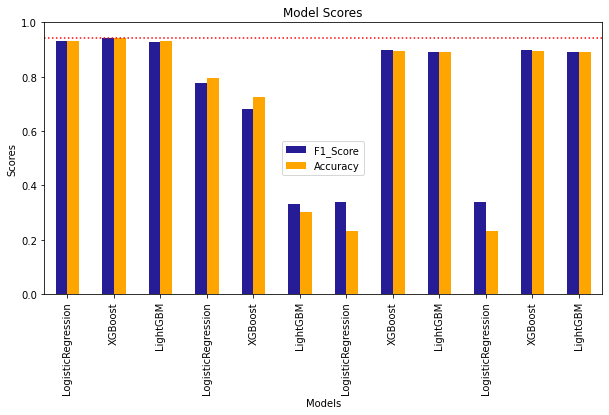

In [123]:
# Display the F1_Score and Accuracy of the models visually

# Set up plot
metrices_df.plot.bar(x='Classification_Model', y=['F1_Score', 'Accuracy'], figsize=(10, 5), color = ['#261C96', 'orange'])
plt.xticks(rotation=90)

# Plot a horizontla line on the highest F1_Score
plt.axhline(y=max(metrices_df['F1_Score']), color='red', linestyle='dotted', linewidth=1.5)

# Title and Labels
plt.title('Model Scores')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0,1)

# Show Plot
plt.show()

## LIME

### Preprocessing

We will use XGBoost on the TF-IDF Vector of Tokenized Words since it is the best model when comparing it to the other models using the F1-Score, Accuracy, Precision, and Recall.

XGBoost on TF-IDF Vector of Tokenized Words model performance is:
Recall = 0.942
Precision = 0.942
F1-Score = 0.942
Accuracy = 0.942

In [53]:
# Define the model
xgb_model = xgb.XGBClassifier(booster = 'dart', eval_metric = 'mlogloss', n_jobs = -1)

# Fit the model
best_model = xgb_model.fit(train_x_tfidf, train_y)

# Predict with model
pred = best_model.predict(test_x_tfidf)
pred

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


array(['Returns & Refunds', 'Sales/Promotions', 'Product Specifications',
       ..., 'Returns & Refunds', 'Product Specifications',
       'Sales/Promotions'], dtype=object)

In [162]:
test_y.unique()

array(['Returns & Refunds', 'Sales/Promotions', 'Product Specifications',
       'Shipping', 'Product Availability', 'Omnichannel',
       'Product Comparison'], dtype=object)

In [187]:
# Converting TF-IDF vectorizer into a pipeline
pipeline = make_pipeline(tfidf_vect, best_model)

# Save the test set as a list
list_X_test = list(test_set)        

# Create two classes
class_names = {0: 'Returns & Refunds', 1:'Sales/Promotions', 2: 'Product Specifications', 
               3: 'Shipping', 4: 'Product Availability', 5:'Omnichannel', 6:'Product Comparison'}

In [231]:
# Create the LIME explainer, with class names for interpretability
exp = LimeTextExplainer(class_names=class_names, random_state=123, bow = False)

# Selecting a random integer between 0 and the length of the test list
# idx = 540 is a good one
idx = random.randint(0, len(list_X_test))
idx_exp = exp.explain_instance(list_X_test[idx], pipeline.predict_proba, num_features = 6)

# Print results
print('Document ID: %d' % idx)
print("")
print('Text: ', list_X_test[idx])
print("")
print('Probability of Returns & Refunds Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,0])
print('Probability of Sales/Promotion Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,1])
print('Probability of Product Specification Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,2])
print('Probability of Shipping Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,3])
print('Probability of Product Availability Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,4])
print('Probability of Omnichannel Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,5])
print('Probability of Product Comparison Class =', pipeline.predict_proba([list_X_test[idx]]).round(3)[0,6])
print("")
print('True class: %s' % list(test_y)[idx])

# print('True class: %s' % class_names.get(list(test_y)[idx]))

Document ID: 475

Text:  I want to get a few different whey protein powders but wanted to ask if you offer discounts when buying in larger quantities?

Probability of Returns & Refunds Class = 0.006
Probability of Sales/Promotion Class = 0.049
Probability of Product Specification Class = 0.716
Probability of Shipping Class = 0.162
Probability of Product Availability Class = 0.004
Probability of Omnichannel Class = 0.06
Probability of Product Comparison Class = 0.003

True class: Sales/Promotions


### Visualizing Explanation

In [232]:
# Display LIME results graphically, showing contribution of each word

idx_exp.show_in_notebook(text=True, predict_proba=True)

When performing a probability prediction for Document ID 475, the class with the highest predicted probability was "Product Specification" of 71.6%. This is means, for that particular text line, the model predicts that this text belongs to the "Product Specification" class. However, the True class that text belongs to was in the Sales/Promotions class. 

When we analyze the visual explanation, we can see that the model predicts the text to be in class 2 "Product Specification". We can also see that the word that provides the most weight is the word "larger".

## SHAP

### Preprocessing

In [236]:
# SHAP is quite computation intensive; we sample data from train and test set to reduce time taken
X_train_sample = shap.sample(train_x_tfidf, 200)
X_test_sample = shap.sample(test_x_tfidf, 20)

# Using SHAP's KernelExplainer (very slow)
exp = shap.KernelExplainer(best_model.predict_proba, X_train_sample, link = 'logit')

# Calculate shap values of test sample using the explainer 
shap_values = exp.shap_values(X_test_sample)

print(f'Length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/20 [00:00<?, ?it/s]

Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to convert it to csr_matrix
Unknown data type: <class 'scipy.sparse.lil.lil_matrix'>, trying to co

Length of SHAP values: 7
Shape of each element: (20, 4155)


In [237]:
# Converting test samples to a dataframe
color_test = pd.DataFrame(X_test_sample.todense())

# Getting the feature names
feature_names=tfidf_vect.get_feature_names()

### Visualizing Explanation

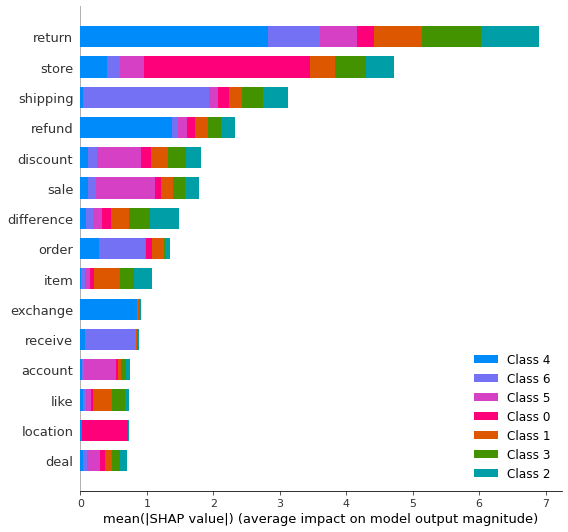

In [238]:
# Create summary plot of shap values

# Plotting
shap.summary_plot(shap_values, color_test, feature_names, max_display=15)

Shap Plot  0


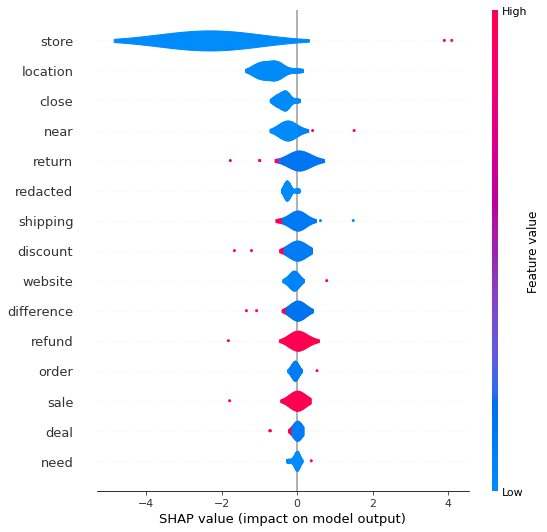

Shap Plot  1


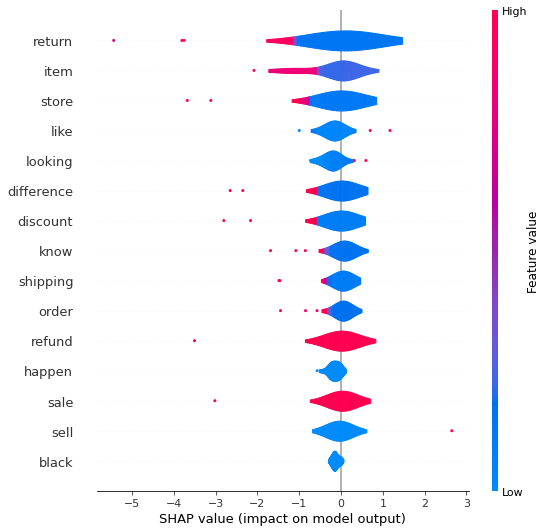

Shap Plot  2


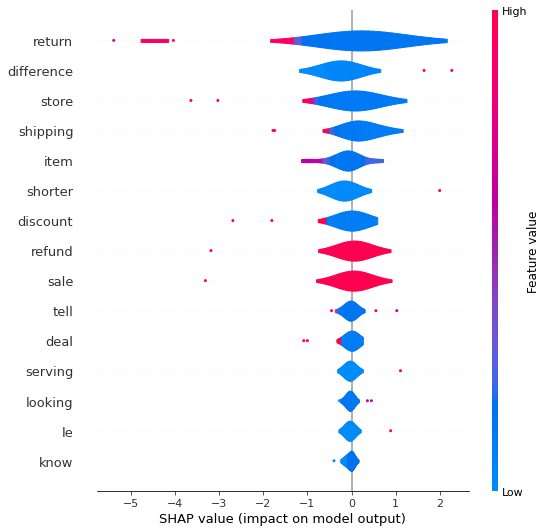

Shap Plot  3


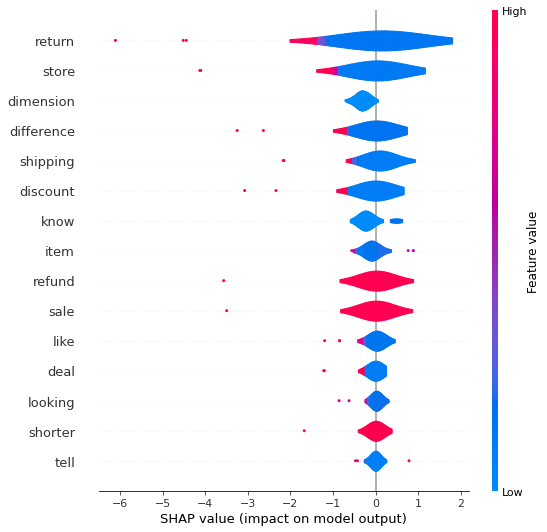

Shap Plot  4


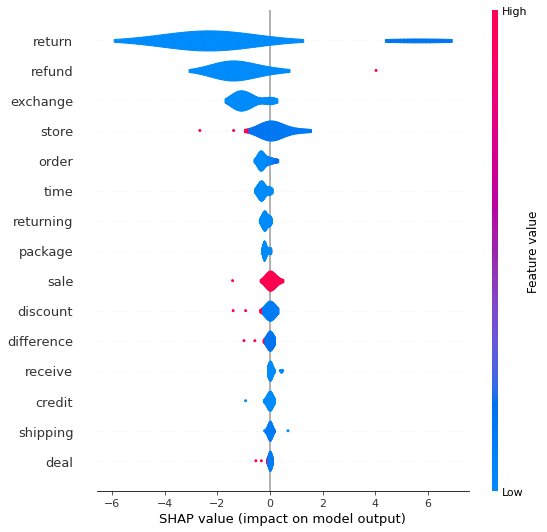

Shap Plot  5


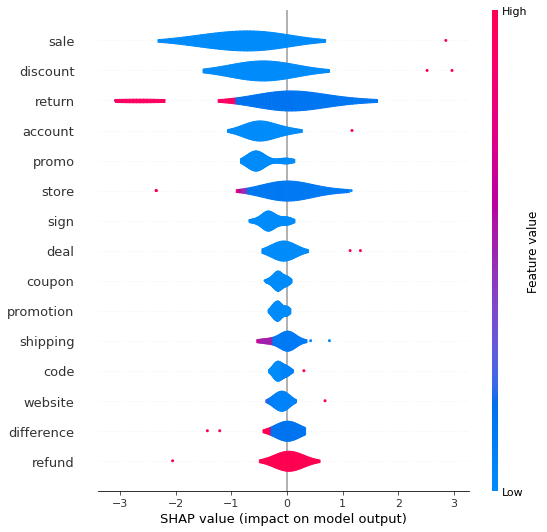

Shap Plot  6


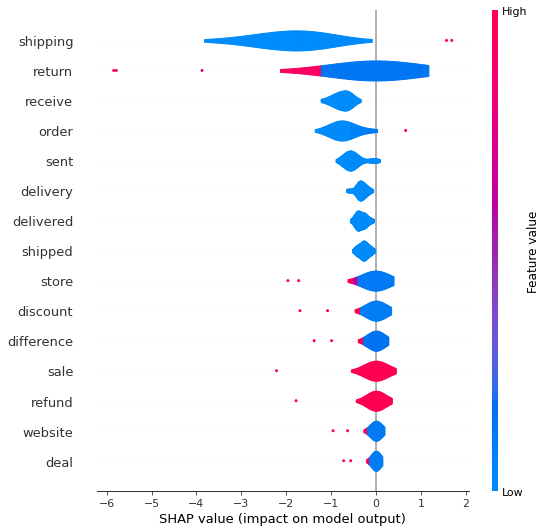

In [239]:
# Looping through and creating a visual for each Shap Value
for c in range(len(shap_values)):
    print('Shap Plot ', c)
    shap.summary_plot(shap_values[c], color_test, feature_names=tfidf_vect.get_feature_names(), plot_type="violin", max_display = 15)

In [240]:
# plotting the first SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[0], shap_values[0][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [241]:
# plotting the second SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[1], shap_values[1][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [242]:
# plotting the third SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[2], shap_values[2][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [243]:
# plotting the fourth SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[3], shap_values[3][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [244]:
# plotting the fifth SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[4], shap_values[4][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [245]:
# plotting the sixth SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[5], shap_values[5][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [246]:
# plotting the seventh SHAP value 
shap.initjs()
shap.force_plot(exp.expected_value[6], shap_values[6][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [247]:
# # Looping to plot all the SHAP values

# for c in range(len(shap_values)):
#     shap.initjs()
#     shap.force_plot(exp.expected_value[c], shap_values[c][0,:], color_test.iloc[0,:], feature_names, link='logit')

In [248]:
# Explaining predictions for a More Than One Sample
shap.initjs()
shap.force_plot(exp.expected_value[0], shap_values[0], color_test, feature_names, link='logit')

## Testing Model On Unseen Data

In [156]:
# Inserting text to test on
unseen_questions = [
    "I know you have a store on Fowler Avenue in Tampa, FL. Do you know if that location has any type of deals going on at this time?",
    "I'm looking for a new car and I want the best deal possible. What deals do you have currently for these cars?",
    "What kind of payment methods do you accept? Because I do not carry any cash.",
    "I am trying to compare these pair of dress shoes, item #1011 with these pair of sports shoes item #20932. Which of these are the most comfortable to wear?",
    "When do you think I'd receive the portable desktop monitor #11024 if I order it today and it's being shipped to Tampa, FL? Do you have an overnight shipping option?"
]

In [157]:
# Transform the data
unseen_questions_vector = tfidf_vect.transform(unseen_questions)

In [159]:
# Create a loop to read each question and predict the topic
num = 1
while(num <= 5):
    for test_question, pred_topic in zip(unseen_questions, best_model.predict(unseen_questions_vector)):
        print(f'Question {num}: {test_question}')
        print(f'Predicted Topic: {pred_topic}')
        print('')
        num+= 1

Question 1: I know you have a store on Fowler Avenue in Tampa, FL. Do you know if that location has any type of deals going on at this time?
Predicted Topic: Omnichannel

Question 2: I'm looking for a new car and I want the best deal possible. What deals do you have currently for these cars?
Predicted Topic: Product Availability

Question 3: What kind of payment methods do you accept? Because I do not carry any cash.
Predicted Topic: Product Availability

Question 4: I am trying to compare these pair of dress shoes, item #1011 with these pair of sports shoes item #20932. Which of these are the most comfortable to wear?
Predicted Topic: Product Comparison

Question 5: When do you think I'd receive the portable desktop monitor #11024 if I order it today and it's being shipped to Tampa, FL? Do you have an overnight shipping option?
Predicted Topic: Shipping

